In [19]:
%matplotlib inline
import pyfolio as pf


In [20]:
stock_rets = pf.utils.get_symbol_rets('FB')


Entire data start date: 2012-05-21
Entire data end date: 2016-09-19


Out-of-Sample Months: 9
Backtest Months: 42


Performance statistics,All history,Backtest,Out of sample
annual_return,0.32,0.33,0.26
annual_volatility,0.41,0.43,0.30
sharpe_ratio,0.88,0.87,0.91
calmar_ratio,0.68,0.69,1.91
stability_of_timeseries,0.95,0.94,0.89
max_drawdown,-0.48,-0.48,-0.14
omega_ratio,1.19,1.18,1.20
sortino_ratio,1.43,1.39,1.57
skew,1.83,1.73,2.62
kurtosis,20.67,19.44,22.03


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,47.90,2012-05-21,2012-09-04,2013-07-25,309
1,22.06,2014-03-10,2014-04-28,2014-07-24,99
2,17.34,2013-10-18,2013-11-25,2013-12-17,43
3,16.57,2015-07-21,2015-08-24,2015-10-19,65
4,13.62,2015-11-11,2016-01-21,2016-01-28,57




[-0.05  -0.106]


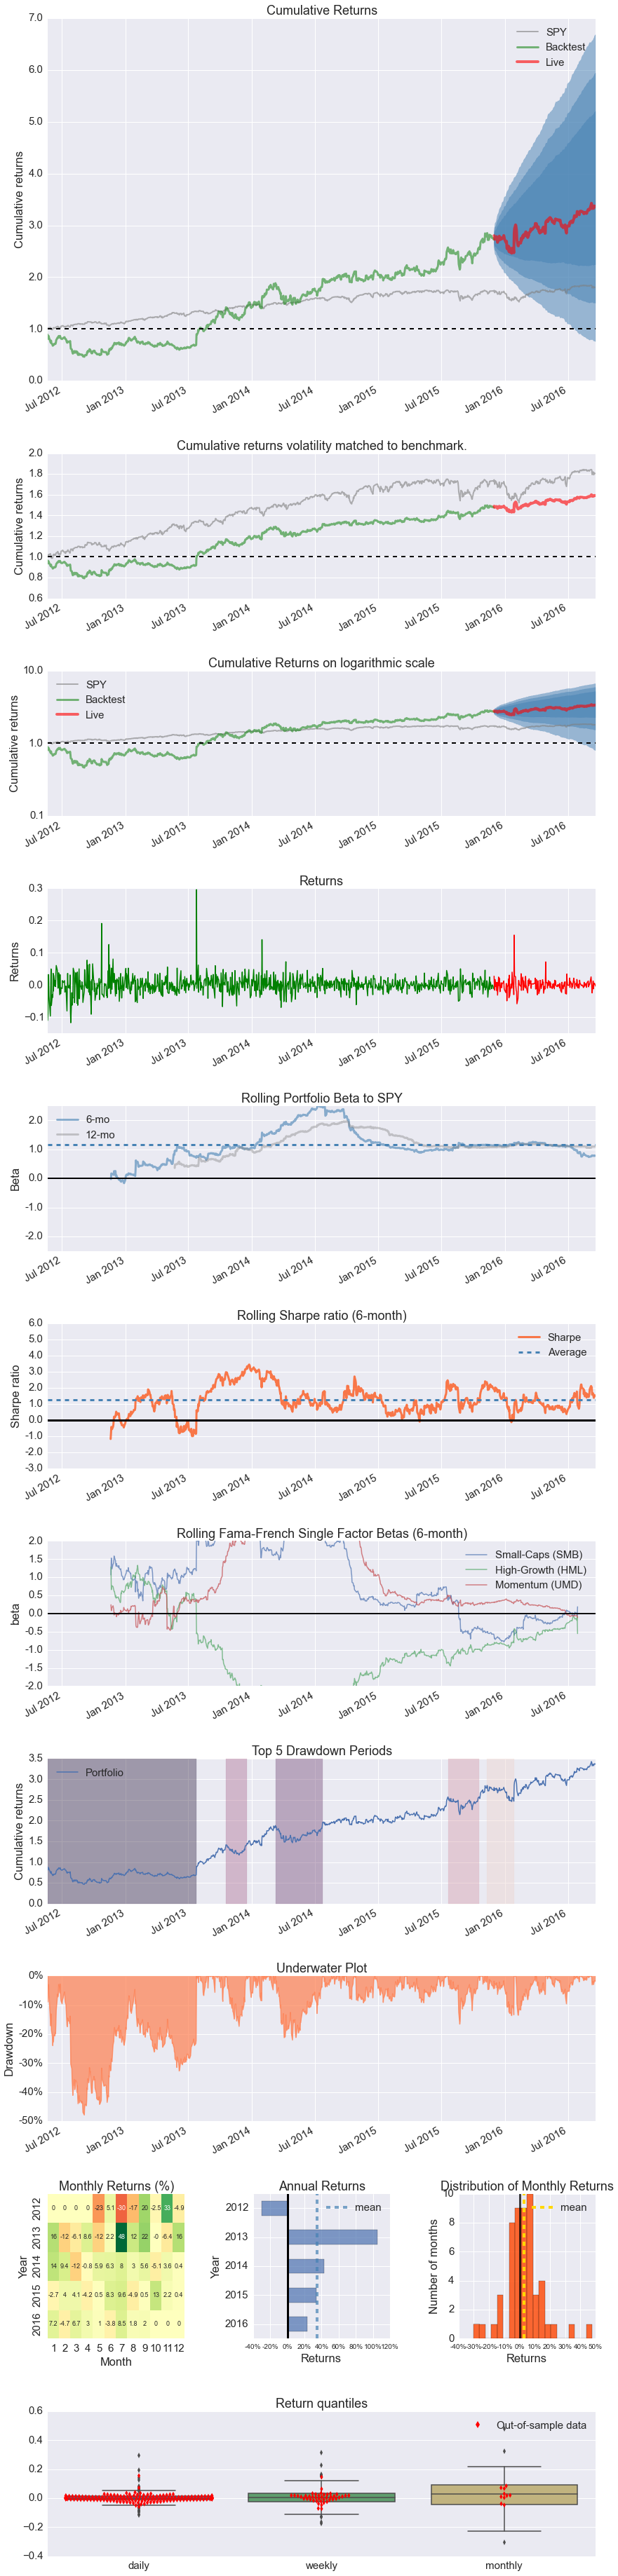

In [21]:
pf.create_returns_tear_sheet(stock_rets, live_start_date='2015-12-1')

In [4]:
import sys
import logbook
import numpy as np
from datetime import datetime
import pytz

from zipline.algorithm import TradingAlgorithm
from zipline.utils.factory import load_from_yahoo
from zipline.finance import commission


In [5]:
# Zipline trading algorithm
# Taken from zipline.examples.olmar
zipline_logging = logbook.NestedSetup([
    logbook.NullHandler(level=logbook.DEBUG),
    logbook.StreamHandler(sys.stdout, level=logbook.INFO),
    logbook.StreamHandler(sys.stderr, level=logbook.ERROR),
])
zipline_logging.push_application()

STOCKS = ['AMD', 'CERN', 'COST', 'DELL', 'GPS', 'INTC', 'MMM']


# On-Line Portfolio Moving Average Reversion

# More info can be found in the corresponding paper:
# http://icml.cc/2012/papers/168.pdf
def initialize(algo, eps=1, window_length=5):
    algo.stocks = STOCKS
    algo.sids = [algo.symbol(symbol) for symbol in algo.stocks]
    algo.m = len(algo.stocks)
    algo.price = {}
    algo.b_t = np.ones(algo.m) / algo.m
    algo.last_desired_port = np.ones(algo.m) / algo.m
    algo.eps = eps
    algo.init = True
    algo.days = 0
    algo.window_length = window_length

    algo.set_commission(commission.PerShare(cost=0))


def handle_data(algo, data):
    algo.days += 1
    if algo.days < algo.window_length:
        return

    if algo.init:
        rebalance_portfolio(algo, data, algo.b_t)
        algo.init = False
        return

    m = algo.m

    x_tilde = np.zeros(m)
    b = np.zeros(m)

    # find relative moving average price for each asset
    mavgs = data.history(algo.sids, 'price', algo.window_length, '1d').mean()
    for i, sid in enumerate(algo.sids):
        price = data.current(sid, "price")
        # Relative mean deviation
        x_tilde[i] = mavgs[sid] / price

    ###########################
    # Inside of OLMAR (algo 2)
    x_bar = x_tilde.mean()

    # market relative deviation
    mark_rel_dev = x_tilde - x_bar

    # Expected return with current portfolio
    exp_return = np.dot(algo.b_t, x_tilde)
    weight = algo.eps - exp_return
    variability = (np.linalg.norm(mark_rel_dev)) ** 2

    # test for divide-by-zero case
    if variability == 0.0:
        step_size = 0
    else:
        step_size = max(0, weight / variability)

    b = algo.b_t + step_size * mark_rel_dev
    b_norm = simplex_projection(b)
    np.testing.assert_almost_equal(b_norm.sum(), 1)

    rebalance_portfolio(algo, data, b_norm)

    # update portfolio
    algo.b_t = b_norm


def rebalance_portfolio(algo, data, desired_port):
    # rebalance portfolio
    desired_amount = np.zeros_like(desired_port)
    current_amount = np.zeros_like(desired_port)
    prices = np.zeros_like(desired_port)

    if algo.init:
        positions_value = algo.portfolio.starting_cash
    else:
        positions_value = algo.portfolio.positions_value + \
            algo.portfolio.cash

    for i, sid in enumerate(algo.sids):
        current_amount[i] = algo.portfolio.positions[sid].amount
        prices[i] = data.current(sid, "price")

    desired_amount = np.round(desired_port * positions_value / prices)

    algo.last_desired_port = desired_port
    diff_amount = desired_amount - current_amount

    for i, sid in enumerate(algo.sids):
        algo.order(sid, diff_amount[i])


def simplex_projection(v, b=1):
    """Projection vectors to the simplex domain
    Implemented according to the paper: Efficient projections onto the
    l1-ball for learning in high dimensions, John Duchi, et al. ICML 2008.
    Implementation Time: 2011 June 17 by Bin@libin AT pmail.ntu.edu.sg
    Optimization Problem: min_{w}\| w - v \|_{2}^{2}
    s.t. sum_{i=1}^{m}=z, w_{i}\geq 0
    Input: A vector v \in R^{m}, and a scalar z > 0 (default=1)
    Output: Projection vector w
    :Example:
    >>> proj = simplex_projection([.4 ,.3, -.4, .5])
    >>> print(proj)
    array([ 0.33333333, 0.23333333, 0. , 0.43333333])
    >>> print(proj.sum())
    1.0
    Original matlab implementation: John Duchi (jduchi@cs.berkeley.edu)
    Python-port: Copyright 2013 by Thomas Wiecki (thomas.wiecki@gmail.com).
    """

    v = np.asarray(v)
    p = len(v)

    # Sort v into u in descending order
    v = (v > 0) * v
    u = np.sort(v)[::-1]
    sv = np.cumsum(u)

    rho = np.where(u > (sv - b) / np.arange(1, p + 1))[0][-1]
    theta = np.max([0, (sv[rho] - b) / (rho + 1)])
    w = (v - theta)
    w[w < 0] = 0
    return w


start = datetime(2004, 1, 1, 0, 0, 0, 0, pytz.utc)
end = datetime(2010, 1, 1, 0, 0, 0, 0, pytz.utc)

# Load price data from yahoo.
data = load_from_yahoo(stocks=STOCKS, indexes={}, start=start, end=end)
data = data.dropna()

# Create and run the algorithm.
olmar = TradingAlgorithm(handle_data=handle_data, initialize=initialize)
results = olmar.run(data)

[2016-09-20 18:21:33.605924] INFO: Loader: Loading stock: AMD
[2016-09-20 18:21:35.034005] INFO: Loader: Loading stock: CERN
[2016-09-20 18:21:35.372039] INFO: Loader: Loading stock: COST
[2016-09-20 18:21:35.679919] INFO: Loader: Loading stock: DELL
[2016-09-20 18:21:35.976124] INFO: Loader: Loading stock: GPS
[2016-09-20 18:21:36.290217] INFO: Loader: Loading stock: INTC
[2016-09-20 18:21:36.581283] INFO: Loader: Loading stock: MMM
[2016-09-20 18:21:37.011246] INFO: Loader: Cache at /Users/mrefermat/.zipline/data/^GSPC_benchmark.csv does not have data from 1990-01-02 00:00:00+00:00 to 2016-09-16 00:00:00+00:00.
[2016-09-20 18:23:12.779717] INFO: Performance: Simulated 1511 trading days out of 1511.
[2016-09-20 18:23:12.780588] INFO: Performance: first open: 2004-01-02 14:31:00+00:00
[2016-09-20 18:23:12.781349] INFO: Performance: last close: 2009-12-31 21:00:00+00:00


/Users/mrefermat/anaconda/lib/python2.7/site-packages/zipline/assets/asset_writer.py:192: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  row = group.sort('end_date').iloc[-1]
/Users/mrefermat/anaconda/lib/python2.7/site-packages/zipline/finance/risk/period.py:100: FutureWarning: pd.rolling_count is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=20).count()
  self.algorithm_returns, self.num_trading_days)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/zipline/finance/risk/period.py:100: FutureWarning: pd.rolling_count is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=19).count()
  self.algorithm_returns, self.num_trading_days)
/Users/mrefermat/anaconda/lib/python2.7/site-packages/zipline/finance/risk/period.py:100: FutureWarning: pd.rolling_count is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(windo

In [6]:
returns, positions, transactions, gross_lev = pf.utils.extract_rets_pos_txn_from_zipline(results)


Entire data start date: 2004-01-02
Entire data end date: 2009-12-31


Out-of-Sample Months: 2
Backtest Months: 69


Performance statistics,All history,Backtest,Out of sample
annual_return,0.08,0.08,0.03
annual_volatility,0.25,0.26,0.22
sharpe_ratio,0.44,0.44,0.25
calmar_ratio,0.14,0.14,0.42
stability_of_timeseries,-0.00,-0.09,0.22
max_drawdown,-0.60,-0.60,-0.07
omega_ratio,1.08,1.08,1.04
sortino_ratio,0.65,0.64,0.34
skew,0.27,0.28,-0.28
kurtosis,4.05,4.10,0.47


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,59.91,2007-11-06,2008-11-20,NaT,NaN
1,22.75,2006-02-16,2006-08-31,2007-05-22,329
2,12.69,2005-07-28,2005-10-12,2006-01-11,120
3,11.66,2004-11-15,2005-04-28,2005-07-28,184
4,10.96,2004-06-25,2004-08-12,2004-11-05,96




[-0.032 -0.069]


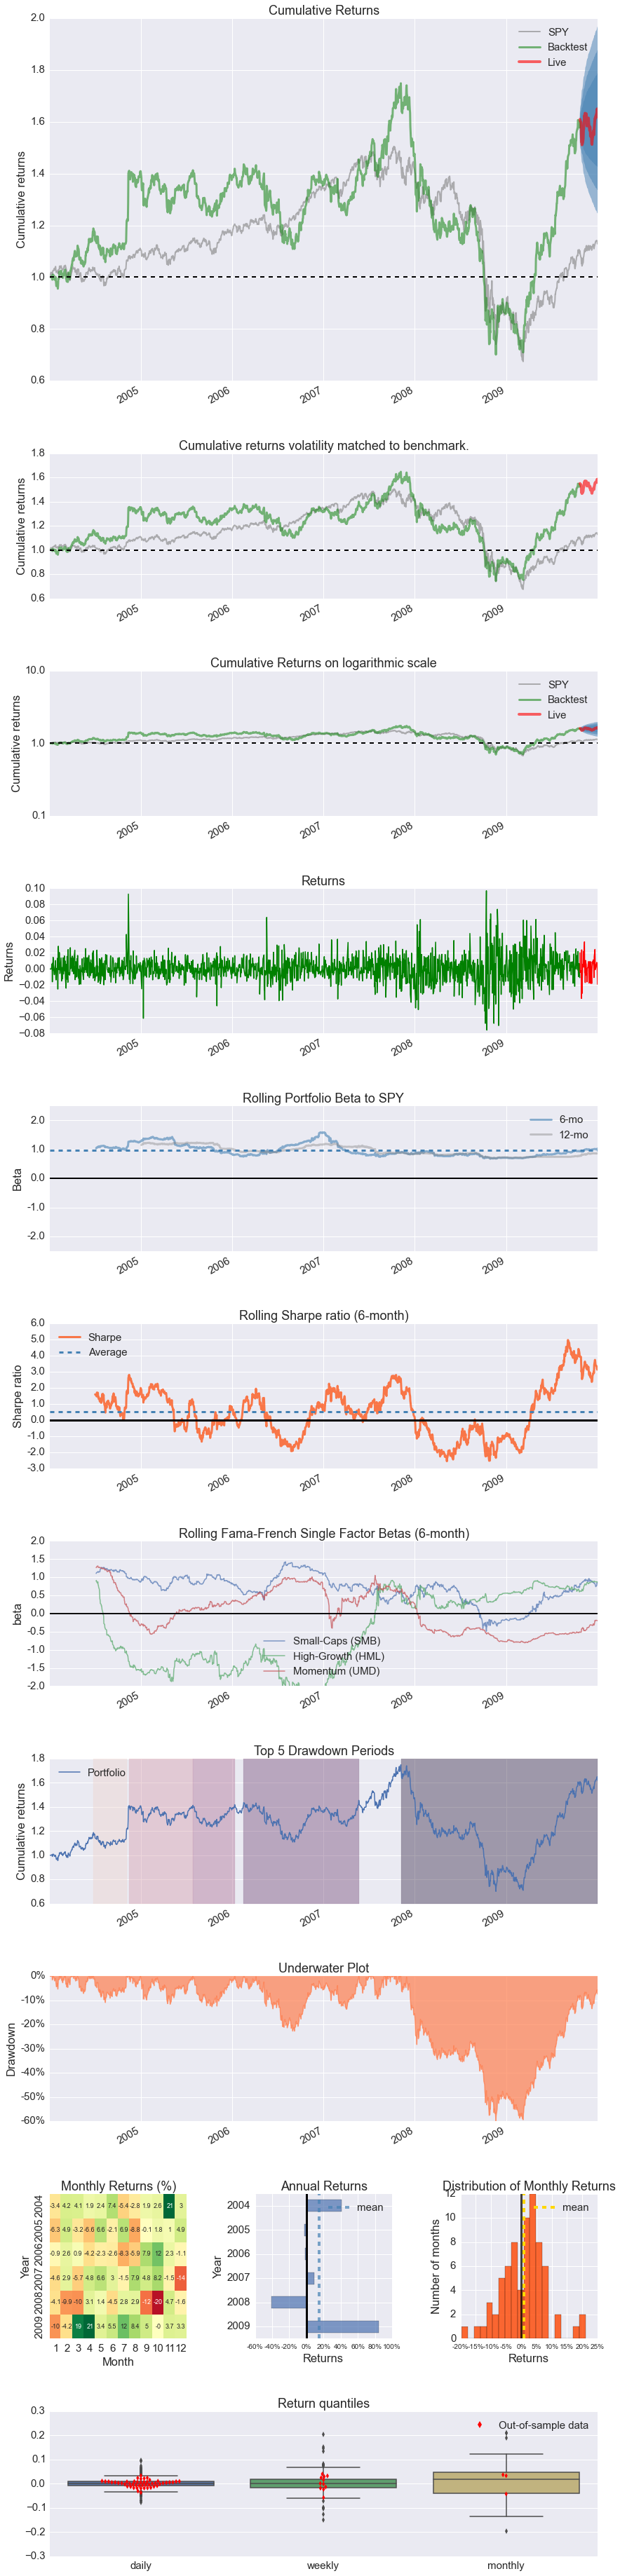

/Users/mrefermat/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Stress Events,mean,min,max
Lehmann,-0.26%,-4.45%,4.41%
Aug07,0.34%,-2.96%,3.02%
Mar08,-0.44%,-3.10%,3.33%
Sept08,-0.64%,-4.35%,3.99%
2009Q1,-0.36%,-4.99%,3.35%
2009Q2,0.71%,-3.78%,6.15%
Low Volatility Bull Market,0.01%,-6.13%,6.40%
GFC Crash,-0.08%,-7.59%,9.70%
Recovery,0.32%,-3.78%,6.15%


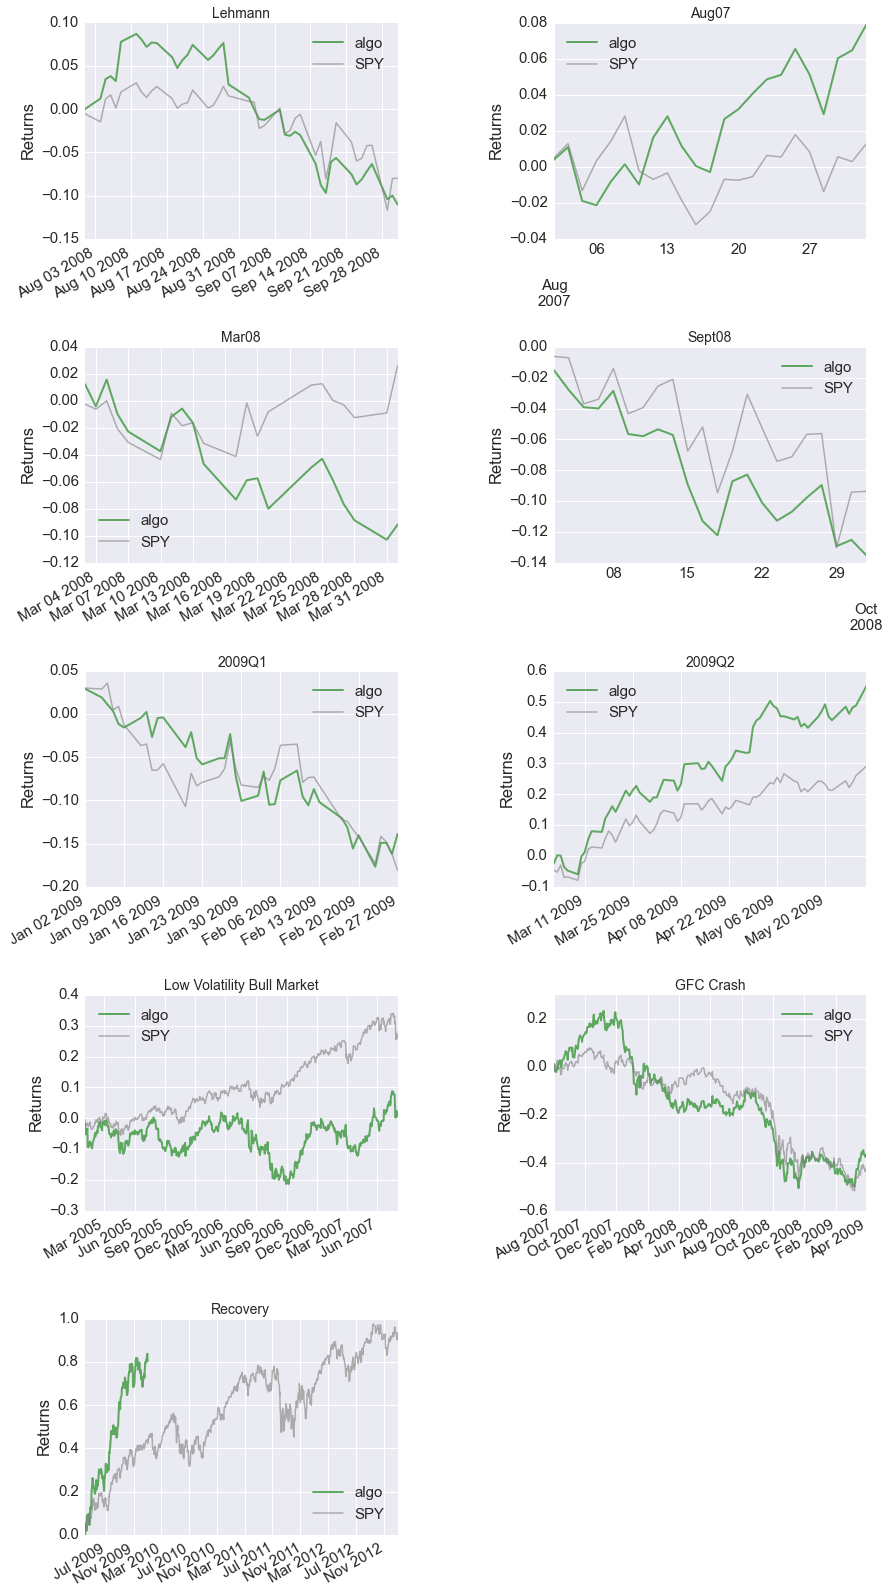

Top 10 long positions of all time,max
sid,
Equity(5 [COST]),100.76%
Equity(4 [MMM]),92.42%
Equity(1 [CERN]),84.49%
Equity(3 [DELL]),71.70%
Equity(2 [AMD]),71.05%
Equity(0 [INTC]),66.92%
Equity(6 [GPS]),62.12%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
Equity(5 [COST]),100.76%
Equity(4 [MMM]),92.42%
Equity(1 [CERN]),84.49%
Equity(3 [DELL]),71.70%
Equity(2 [AMD]),71.05%
Equity(0 [INTC]),66.92%
Equity(6 [GPS]),62.12%


All positions ever held,max
sid,
Equity(5 [COST]),100.76%
Equity(4 [MMM]),92.42%
Equity(1 [CERN]),84.49%
Equity(3 [DELL]),71.70%
Equity(2 [AMD]),71.05%
Equity(0 [INTC]),66.92%
Equity(6 [GPS]),62.12%


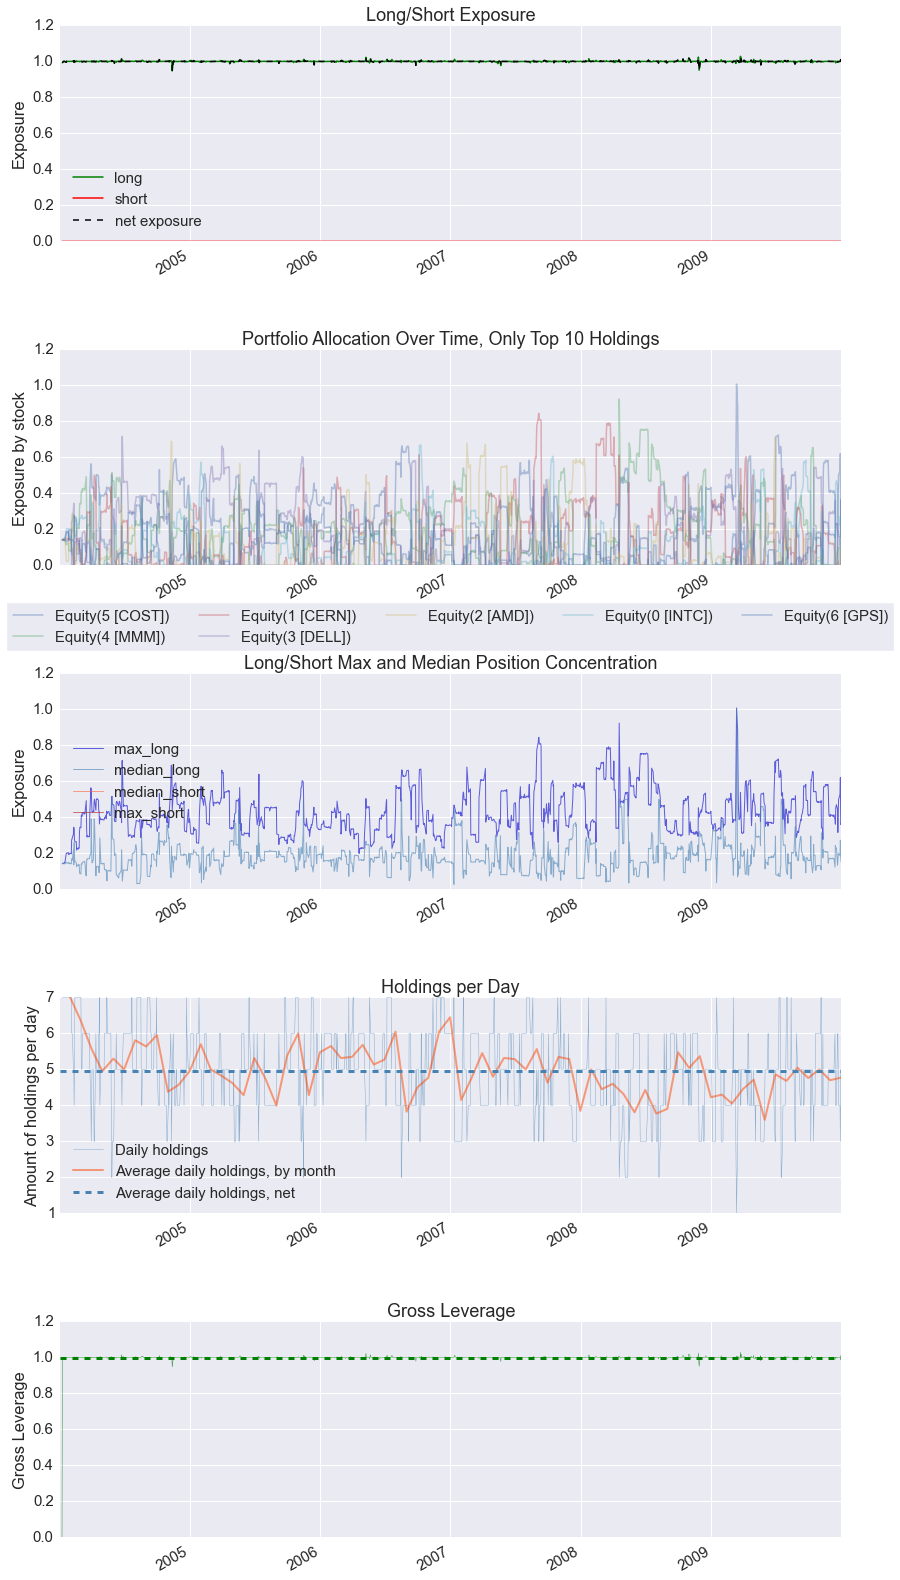

/Users/mrefermat/anaconda/lib/python2.7/site-packages/pyfolio/plotting.py:1210: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  **kwargs)


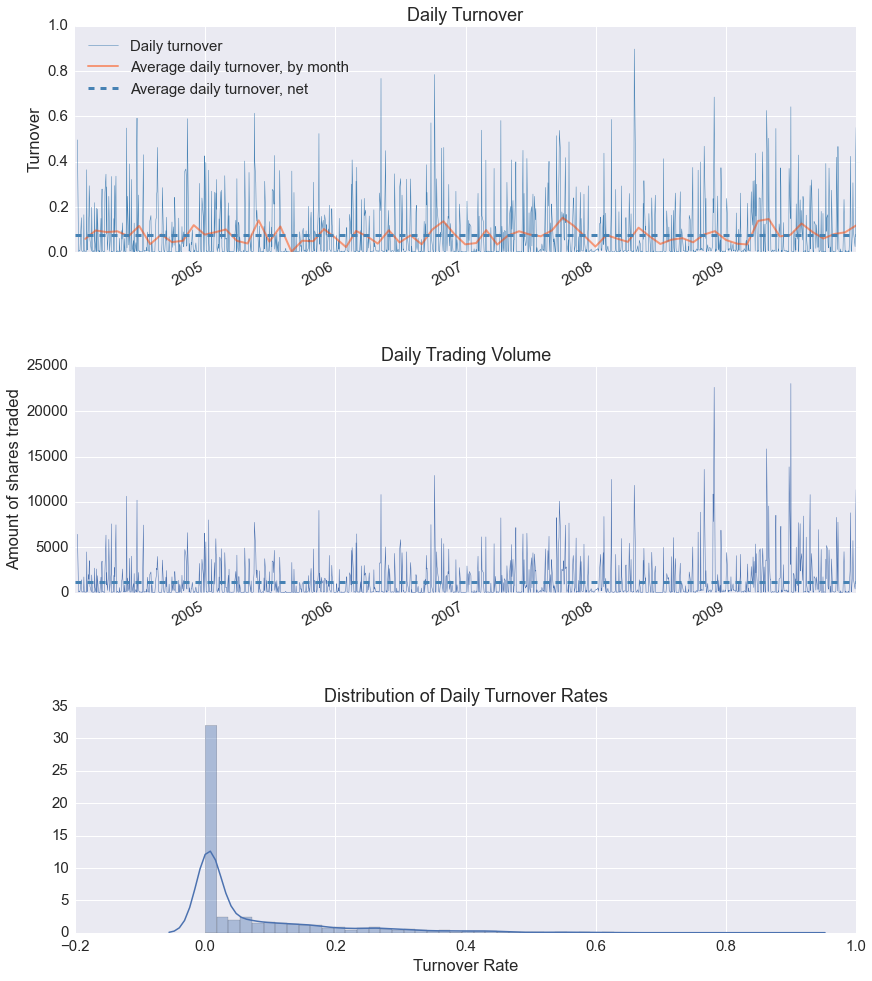

Summary stats,All trades,Long trades
Total number of round_trips,3730.00,3730.00
Percent profitable,0.49,0.49
Winning round_trips,1836.00,1836.00
Losing round_trips,1894.00,1894.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$69298.96,$69298.96
Gross profit,$381232.66,$381232.66
Gross loss,$-311933.70,$-311933.70
Profit factor,$1.22,$1.22
Avg. trade net profit,$18.58,$18.58
Avg. winning trade,$207.64,$207.64
Avg. losing trade,$-164.70,$-164.70
Ratio Avg. Win:Avg. Loss,$1.26,$1.26
Largest winning trade,$15553.08,$15553.08
Largest losing trade,$-12474.06,$-12474.06


Duration stats,All trades,Long trades
Avg duration,22 days 06:12:55.979356,22 days 06:12:55.979356
Median duration,18 days 00:00:00,18 days 00:00:00
Avg # round_trips per day,34.54,34.54
Avg # round_trips per month,725.28,725.28


Return stats,All trades,Long trades
Avg returns all round_trips,0.01%,0.01%
Avg returns winning,0.17%,0.17%
Avg returns losing,-0.14%,-0.14%
Median returns all round_trips,-0.00%,-0.00%
Median returns winning,0.02%,0.02%
Median returns losing,-0.01%,-0.01%
Largest winning trade,12.13%,12.13%
Largest losing trade,-9.14%,-9.14%


Symbol stats,Equity(0 [INTC]),Equity(1 [CERN]),Equity(2 [AMD]),Equity(3 [DELL]),Equity(4 [MMM]),Equity(5 [COST]),Equity(6 [GPS])
Avg returns all round_trips,0.04%,0.03%,0.00%,-0.04%,0.01%,0.03%,-0.00%
Avg returns winning,0.17%,0.20%,0.38%,0.13%,0.11%,0.13%,0.13%
Avg returns losing,-0.07%,-0.17%,-0.36%,-0.20%,-0.09%,-0.06%,-0.11%
Median returns all round_trips,-0.00%,0.00%,-0.00%,-0.00%,0.00%,-0.00%,-0.00%
Median returns winning,0.03%,0.02%,0.07%,0.02%,0.01%,0.01%,0.02%
Median returns losing,-0.00%,-0.01%,-0.02%,-0.01%,-0.01%,-0.01%,-0.01%
Largest winning trade,2.34%,5.92%,12.13%,2.48%,2.25%,2.95%,3.53%
Largest losing trade,-4.59%,-4.67%,-9.14%,-5.86%,-3.83%,-3.41%,-8.28%


Profitability (PnL / PnL total) per name,pnl
symbol,
Equity(0 [INTC]),0.40%
Equity(5 [COST]),0.37%
Equity(1 [CERN]),0.32%
Equity(4 [MMM]),0.18%
Equity(6 [GPS]),0.04%
Equity(2 [AMD]),-0.04%
Equity(3 [DELL]),-0.27%


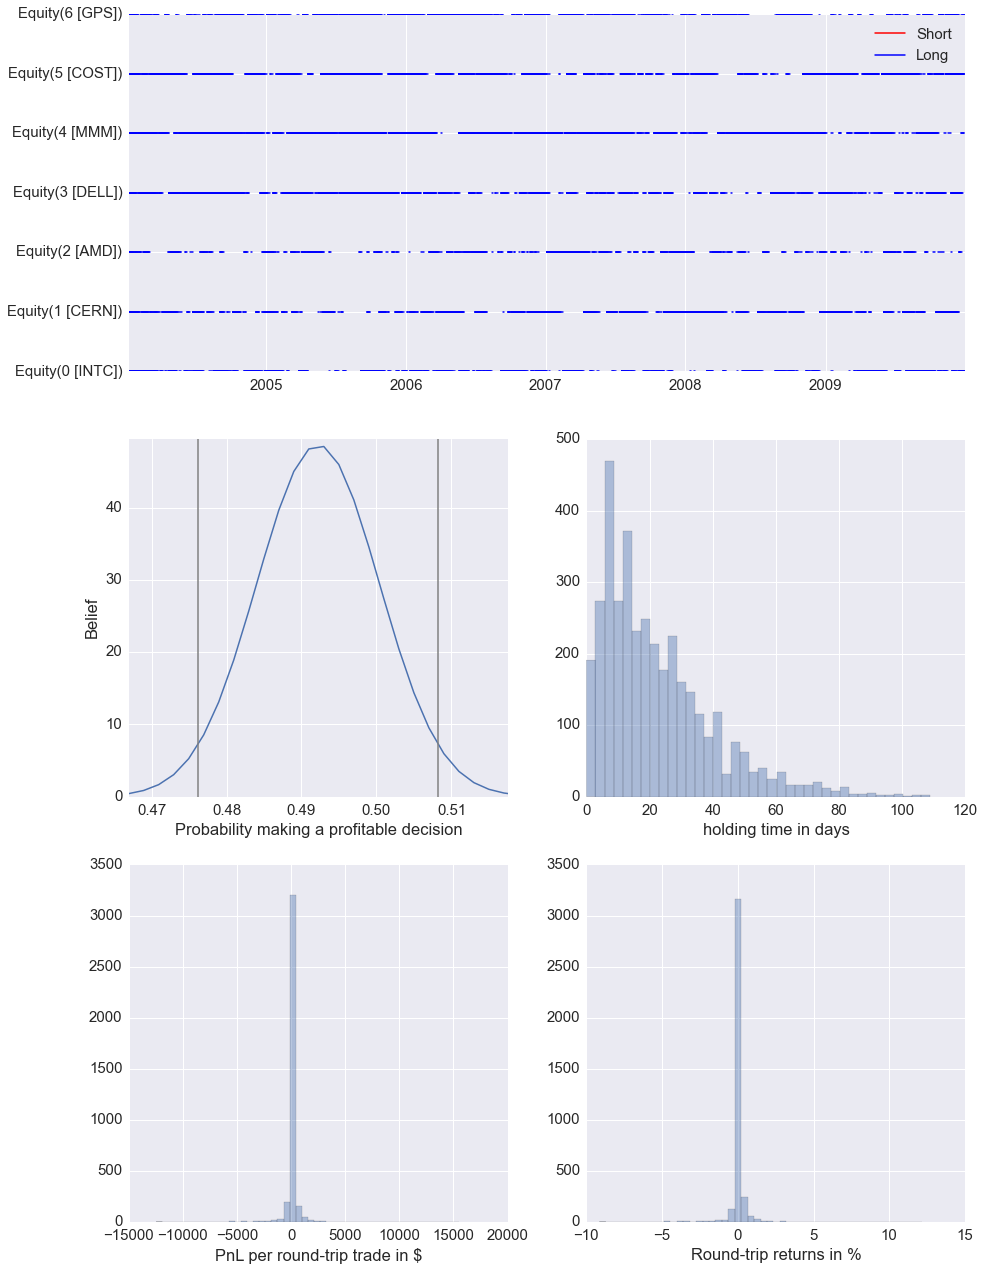

In [7]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          gross_lev=gross_lev, live_start_date='2009-10-22', round_trips=True)

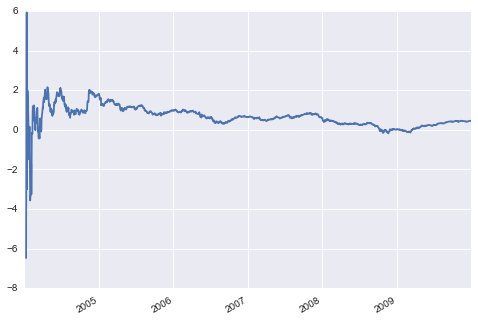

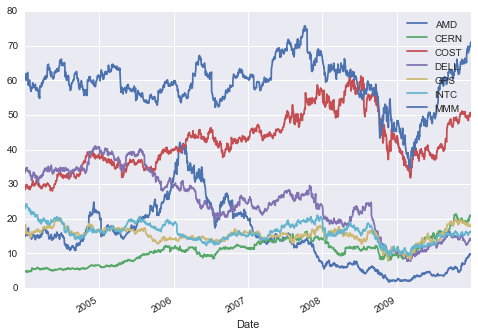

In [18]:
data.plot()